In [1]:
%%capture
import sys
import time
from datetime import datetime as dt
import pytz
IST=pytz.timezone('Asia/Kolkata')

In [3]:
import numpy as np
import pandas as pd
import caching_policy as cp
import importlib
importlib.reload(cp)
from data_loader import *
from network_generator import *
from matplotlib import pyplot as plt
from data_generation import *
import h5py
import seaborn as sns
import ast

In [3]:
folder_path='/home/studio-lab-user/iplc/data/'

In [4]:
accuracy={}
num_files=3
cache_size=2
num_states=50 # for generating synthetic data
total_time=10000000#len(data)
prob='exp' # at each node while generating the data, instead of 
# prob='unif'
store=h5py.File(folder_path+f'synthetic_fsm_num_files{num_files}_cache_size{cache_size}_S{num_states}_T{total_time}_{prob}.h5','w')

In [5]:

if prob=='exp':
    p=np.zeros(cache_size)
    for i in range(len(p)):
        p[i]=1./(2**(i+1))
    p=p/p.sum()
else:
    p=None
data=generate_data_fsm(num_files,cache_size,num_states,total_time,p)
data=data[:,np.newaxis]

100%|██████████| 10000000/10000000 [06:42<00:00, 24845.34it/s]

int64


In [6]:
store.create_dataset('data',data=data)
store['data'].attrs['num_files']=num_files
store['data'].attrs['cache_size']=cache_size
store['data'].attrs['total_time']=total_time
store['data'].attrs['num_states']=num_states

In [7]:
cumulative_req_h,hits_h,rec_hitrate_h,rec_states_h=cp.hedge_fsm_single_cache(data,total_time,num_files,cache_size)
accuracy['hedge']=rec_hitrate_h[-1]
print(accuracy['hedge'])
store['hedge/rec_hitrate']=rec_hitrate_h
store['hedge/rec_states']=rec_states_h

100%|██████████| 10000000/10000000 [13:09<00:00, 12669.36it/s]


0.8608186


In [8]:
# df=pd.DataFrame(list(cumulative_req_h.items()),columns=['state','visits'])
# df['hits']=df['state'].map(hits_h)
# # df[['state']]=pd.DataFrame(df['state'].tolist(),index=df.index)
# df=df.loc[:,['state','visits','hits']]
# df.set_index(['state'],inplace=True,drop=True)
# df['hitrate']=df['hits']/df['visits']
# accuracy['hedge']=df['hits'].sum()/df['visits'].sum()


# store.create_dataset('hedge/df/state',data=df.index.to_numpy(dtype='S'))
# store.create_dataset('hedge/df/hits',data=df['hits'].to_numpy())
# store.create_dataset('hedge/df/visits',data=df['visits'].to_numpy())


In [ ]:
for k in range(1,15):
    cumulative_req_m,hits_m,rec_hitrate_m,rec_states_m=cp.markov_online_single_cache(data,total_time,num_files,cache_size,k)
    # df=pd.DataFrame(list(cumulative_req_m.items()),columns=['state','visits'])
    # df['hits']=df['state'].map(hits_m)
    # # df[['state']]=pd.DataFrame(df['state'].tolist(),index=df.index)
    # df=df.loc[:,['state','visits','hits']]
    # df.set_index(['state'],inplace=True,drop=True)
    # df['hitrate']=df['hits']/df['visits']
    # accuracy[k]=df['hits'].sum()/df['visits'].sum()
    accuracy[k]=rec_hitrate_m[-1]
    print(f'order {k} markov: ',accuracy[k])

100%|██████████| 9999999/9999999 [05:24<00:00, 30802.07it/s]


order 1 markov:  0.7749247


100%|██████████| 9999998/9999998 [05:29<00:00, 30380.86it/s]


order 2 markov:  0.788698


100%|██████████| 9999997/9999997 [05:41<00:00, 29293.69it/s]


order 3 markov:  0.8312518


100%|██████████| 9999996/9999996 [05:54<00:00, 28205.73it/s]


order 4 markov:  0.8581127


100%|██████████| 9999995/9999995 [06:09<00:00, 27097.27it/s]


order 5 markov:  0.8859552


100%|██████████| 9999994/9999994 [06:21<00:00, 26237.33it/s]


order 6 markov:  0.9182784


100%|██████████| 9999993/9999993 [06:38<00:00, 25095.97it/s]


order 7 markov:  0.9416117


100%|██████████| 9999992/9999992 [06:56<00:00, 23991.12it/s]


order 8 markov:  0.9594462


100%|██████████| 9999991/9999991 [07:08<00:00, 23336.45it/s]


order 9 markov:  0.9719012


100%|██████████| 9999990/9999990 [07:21<00:00, 22664.41it/s]


order 10 markov:  0.9753207


100%|██████████| 9999989/9999989 [07:37<00:00, 21859.23it/s]


order 11 markov:  0.985568


100%|██████████| 9999988/9999988 [07:45<00:00, 21492.73it/s]


order 12 markov:  0.9707158


100%|██████████| 9999987/9999987 [08:00<00:00, 20797.53it/s]


order 13 markov:  0.9682285


 57%|█████▋    | 5702337/9999986 [04:34<03:56, 18141.82it/s]

In [ ]:
cumulative_req_f,hits_f,rec_hitrate_f=cp.ftpl(data,total_time,num_files,cache_size)
accuracy['ftpl']=hits_f/cumulative_req_f
accuracy['ftpl']
store['data'].attrs['accuracy']=str(accuracy)

In [ ]:
store.close()

# Plot

In [33]:
def lb(Q,k,C,N,T):
    '''
    Lower bound as given by eq 7 (\label{cache-miss-hedge}) in the paper.
    Note that eq 7 gives an upperbound on cache misses, 
    but for plotting we convert it into a lower bound on cache hits.
    '''
    tmp=min(1,np.sqrt(np.log(Q)/(2*(k+1))))
    tmp2=np.log(N*np.e/C)
    return 1-(tmp + np.sqrt( 2*(N**k) * (C/T) * tmp2 * tmp) + (N**k)*(C/T) * tmp2)
def lb_asym(Q,k,C,N,T):
    return 1-min(1,np.sqrt(np.log(Q)/(2*(k+1))))
for i in range(1,15): 
    print(i,lb(1000,i,3,10,1e100),1-min(1,np.sqrt(np.log(1000)/(2*(i+1)))))

1 0.0 0
2 0.0 0
3 0.07076945278754043 0.07076945278754043
4 0.168870931865445 0.168870931865445
5 0.24128643530742688 0.24128643530742688
6 0.2975677318375337 0.2975677318375337
7 0.3429347787803835 0.3429347787803835
8 0.3805129685250269 0.3805129685250269
9 0.4123029998808001 0.4123029998808001
10 0.4396528965744805 0.4396528965744805
11 0.4635084934276632 0.4635084934276632
12 0.4845556331227716 0.4845556331227716
13 0.5033053798580727 0.5033053798580727
14 0.5201474087811919 0.5201474087811919


1 0.011058266955511487 0.7749247
2 0.1925324562324351 0.788698
3 0.3007125943658657 0.8312518
4 0.3745383300770425 0.8581127
5 0.42903422421390947 0.8859552
6 0.4713884084950095 0.9182784
7 0.5055291334777557 0.9416117
8 0.5338083962439105 0.9594462
9 0.5577318118252147 0.9719012
10 0.5783138281619123 0.9753207
11 0.5962662281162175 0.985568
12 0.6121051388769143 0.9707158
13 0.6262151590330081 0.9682285
14 0.6388895365021876 0.9595043


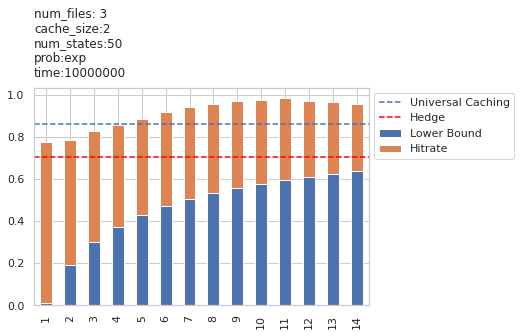

In [43]:
num_files=3
cache_size=2
num_states=50 # for generating synthetic data
total_time=int(1e7)
# prob='unif'
prob='exp'
store_path=folder_path+f'synthetic_fsm_num_files{num_files}_cache_size{cache_size}_S{num_states}_T{total_time}_{prob}.h5'
with h5py.File(store_path,'r') as store:
    sns.set(style="whitegrid")
    accuracy=ast.literal_eval(store['data'].attrs['accuracy'])
    acc_hedge=accuracy.pop('hedge')
    acc_ftpl=accuracy.pop('ftpl')
    for i in list(accuracy.keys()):
        x=accuracy.pop(i)
        b=max(0,lb_asym(num_states,i,cache_size,num_files,total_time))
        print(i,b,x)
        accuracy[i]=[b,(x-b)]
    ax=pd.DataFrame.from_dict(accuracy,orient='index',columns=['Lower Bound','Hitrate']).plot(kind='bar',stacked=True)
    ax.axhline(acc_hedge,ls='--',label='Universal Caching')
    ax.axhline(acc_ftpl,ls='--',label='Hedge',c='red')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    # ax.set_xlabel('Order of Markov Prefetcher with Hedge ($k$)')
    # ax.set_ylabel('Hitrate')
    ax.text(0,1.05,f'num_files: {num_files}\ncache_size:{cache_size}\nnum_states:{num_states}\nprob:{prob}\ntime:{total_time}',transform=ax.transAxes)
    # ax.get_figure().savefig(folder_path+f'synthetic_fsm_num_files{num_files}_cache_size{cache_size}_S{num_states}_T{total_time}_{prob}_lb.png',bbox_inches="tight")

In [13]:
!conda install -c conda-forge miktex

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
